<a href="https://colab.research.google.com/github/google/jax-md/blob/main/notebooks/cargese_swap_mc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jul 12 10:53:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install git+https://github.com/google/jax-md.git@tree_simulations

In [ ]:
#@title Imports & Utils

from jax.config import config
config.update('jax_enable_x64', True)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def pdf(sigma, m, M):
  A = 1 / 2 / (1 / m ** 2 - 1 / M ** 2)
  return A / sigma ** 3

def random_sigma(key, shape, sigma_min, sigma_max):
  m = sigma_min
  M = sigma_max
  A = 1 / 2 / (1 / m ** 2 - 1 / M ** 2)

  def cdf(sigma):
    return 2 * A * (1 / m ** 2 - 1 / sigma ** 2)

  def inv_cdf(p):
    return 1 / (1 / m ** 2 - p / (2 * A)) ** (1 / 2)

  sigmas = random.uniform(key, shape)

  return inv_cdf(sigmas)

# Swap Monte Carlo in JAX MD

## Defining the interaction

<div>
<img src="https://raw.githubusercontent.com/google/jax-md/swap_mc_notebook/notebooks/images/swap_mc/potential_equation.png" width="500"/>
</div>


In [ ]:
import jax.numpy as jnp

eps = 1e-7
cutoff = 1.25

def potential(r, sigma, c0, c2, c4):
  z = r / sigma
  F = c0 + c2 * z**2 + c4 * z**4
  return jnp.where(z < cutoff + eps, (z + eps)**-12 + F, 0.0)

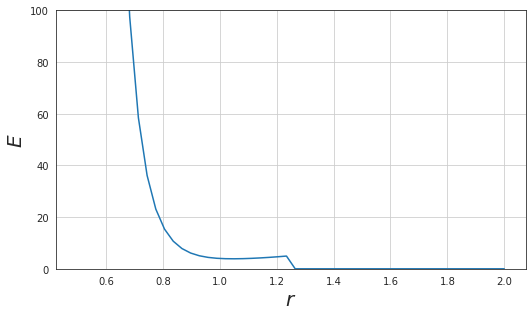

In [ ]:
rs = jnp.linspace(0.5, 2)
plt.plot(rs, potential(rs, 1.0, c0=1.0, c2=1.0, c4=1.0))

plt.ylim([0, 100])
format_plot('$r$', '$E$')
finalize_plot((1.25, 0.75))

In [ ]:
from jax import grad
import scipy

f = lambda c: potential(cutoff, 1.0, *c)
df = lambda c: grad(potential)(cutoff, 1.0, *c)
d2f = lambda c: grad(grad(potential))(cutoff, 1.0, *c)

objective = lambda c: (f(c), df(c), d2f(c))

c0, c2, c4 = scipy.optimize.root(objective, x0=(1.0, 1.0, 1.0)).x

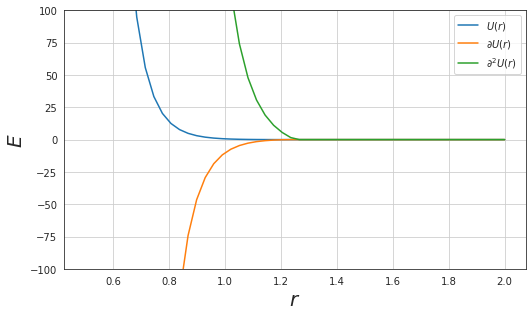

In [ ]:
#@title Plot potential
from jax import vmap

U = lambda dr, sigma, **kwargs: potential(dr, sigma, c0, c2, c4)

plt.plot(rs, U(rs, 1.0), label='$U(r)$')
plt.plot(rs, vmap(grad(U), (0, None))(rs, 1.0), label='$\\partial U(r)$')
plt.plot(rs, vmap(grad(grad(U)), (0, None))(rs, 1.0), label='$\\partial^2 U(r)$')
plt.ylim([-100, 100]) 
plt.legend()

format_plot('$r$', '$E$')
finalize_plot((1.25, 0.75))

In [ ]:
U = lambda dr, sigma, **kwargs: potential(dr, sigma, c0, c2, c4)

## Initializing a system

In [ ]:
from jax_md import quantity

N = 1500
number_density = 1.0
spatial_dimension = 3

box_size = quantity.box_size_at_number_density(N, 
                                               number_density, 
                                               spatial_dimension)

In [ ]:
from jax_md import space

displacement, shift = space.periodic(box_size)
metric = space.metric(displacement)

In [ ]:
from jax import random

key = random.PRNGKey(0)

key, pos_key, sigma_key = random.split(key, 3)

# Initialize positions.
position = random.uniform(pos_key, (N, spatial_dimension), maxval=box_size) 


<div>
<img src="https://raw.githubusercontent.com/google/jax-md/swap_mc_notebook/notebooks/images/swap_mc/radii_distribution.png" width="500"/>
</div>


In [ ]:
# Initialize radii.
sigma_min = 0.73
sigma_max = 1.62
sigma = random_sigma(sigma_key, (N,), sigma_min, sigma_max)
sigma_fn = lambda si, sj: (si + sj) / 2.0 * (1 - 0.2 * jnp.abs(si - sj))

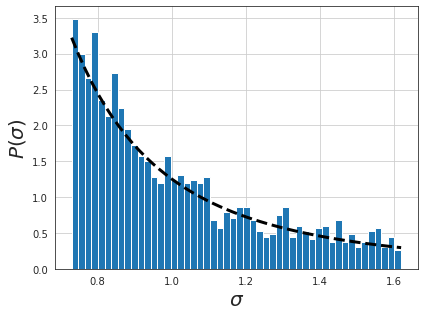

In [ ]:
#@title Plot Radii Distribution
plt.hist(sigma, 50, density=True)
s = jnp.linspace(sigma_min, sigma_max)
plt.plot(s, 3.75 * pdf(s, sigma_min, sigma_max), 'k--', linewidth=3)

format_plot('$\\sigma$', '$P(\\sigma)$')
finalize_plot((1, 0.75))

In [ ]:
from jax_md import smap

energy_fn = smap.pair_neighbor_list(U, metric, sigma=(sigma_fn, sigma))

In [ ]:
from jax_md import partition

neighbor_fn = partition.neighbor_list(displacement, 
                                      box_size, 
                                      cutoff * sigma_max, 
                                      dr_threshold=0.5)

In [ ]:
nbrs = neighbor_fn(position)
energy_fn(position, neighbor=nbrs)

DeviceArray(1.08579963e+15, dtype=float64)

In [ ]:
from jax_md import minimize

clipped_force_fn = quantity.clipped_force(energy_fn, max_force=1.0)
init_fn, step_fn = minimize.fire_descent(clipped_force_fn, shift)

In [ ]:
from jax.lax import fori_loop

state = init_fn(position, neighbor=nbrs)

def body_fn(i, state_nbrs):
  state, nbrs = state_nbrs
  state = step_fn(state, neighbor=nbrs)
  nbrs = neighbor_fn(state.position, nbrs)
  return state, nbrs

state, nbrs = fori_loop(0, 2000, body_fn, (state, nbrs))

In [ ]:
#@title Print Info
minimized_position = state.position

print(f'Energy = {energy_fn(state.position, neighbor=nbrs):0.3}.')
print(f'Max Force = {jnp.max(jnp.abs(state.force)):0.3}.')
print(f'Did neighborlist overflow: {nbrs.did_buffer_overflow}.')

Energy = 4.99e+02.
Max Force = 0.6.
Did neighborlist overflow: False.


In [ ]:
from jax_md.colab_tools import renderer

renderer.render(box_size, 
                {
                    'particles': renderer.Sphere(state.position, sigma)
                },
                resolution=(512, 512))

## Hybrid Swap MC and Equilibration


<div>
<img src="https://raw.githubusercontent.com/google/jax-md/swap_mc_notebook/notebooks/images/swap_mc/swap_mc_schematic.png" width="500"/>
</div>


In [ ]:
dt = 0.01
t_md = 0.1
md_steps = int(t_md // dt)

In [ ]:
from jax_md import dataclasses
from jax_md import simulate


@dataclasses.dataclass
class SwapMCState:
  md: simulate.NVTNoseHooverState
  sigma: jnp.ndarray
  key: jnp.ndarray
  neighbors: partition.NeighborList

In [ ]:
def hybrid_swap_mc(energy_fn, neighbor_fn, shift_fn, kT, N_swap):
  nvt_init_fn, nvt_step_fn = simulate.nvt_nose_hoover(energy_fn, 
                                                      shift_fn, 
                                                      dt, 
                                                      kT=kT, 
                                                      chain_length=3)
  
  def init_fn(key, position, sigma, nbrs):
    key, sim_key = random.split(key)
    md_state = nvt_init_fn(sim_key, position, neighbor=nbrs)
    return SwapMCState(md_state, sigma, key, nbrs)

  def md_step_fn(i, state):
    md, sigma, key, nbrs = dataclasses.unpack(state)
    md = nvt_step_fn(md, neighbor=nbrs, sigma=sigma)
    nbrs = neighbor_fn(md.position, nbrs)
    return SwapMCState(md, sigma, key, nbrs)

  def swap_step_fn(i, state):
    md, sigma, key, nbrs = dataclasses.unpack(state)

    # Swap a random pair of particle radii.
    key, particle_key, accept_key = random.split(key, 3)
    ij = random.randint(particle_key, (2,), jnp.array(0), jnp.array(N))
    new_sigma = sigma.at[ij].set([sigma[ij[1]], sigma[ij[0]]])

    # Collect positions and radii in neighborhoods around selected particles.
    nbrs_ij = nbrs.idx[ij]
    mask = nbrs_ij < N
    R_ij = md.position[ij]
    R_neigh = md.position[nbrs_ij]

    sigma_ij = sigma[ij][:, None]
    sigma_neigh = sigma[nbrs_ij]

    new_sigma_ij = new_sigma[ij][:, None]
    new_sigma_neigh = new_sigma[nbrs_ij]

    d = space.map_neighbor(metric)
    dR = d(R_ij, R_neigh)

    # Compute the energy before the swap.
    energy = U(dR, sigma_fn(sigma_ij, sigma_neigh))
    energy = jnp.sum(energy * mask)

    # Compute the energy after the swap.
    new_energy = U(dR, sigma_fn(new_sigma_ij, new_sigma_neigh))
    new_energy = jnp.sum(new_energy * mask)

    # Accept or reject with a metropolis probability.
    p = random.uniform(accept_key, ())
    accept_prob = jnp.minimum(1, jnp.exp(-(new_energy - energy) / kT))
    sigma = jnp.where(p < accept_prob, new_sigma, sigma)

    return SwapMCState(md, sigma, key, nbrs)

  def block_fn(state):
    state = fori_loop(0, md_steps, md_step_fn, state)
    state = fori_loop(0, N_swap, swap_step_fn, state)
    return state

  return init_fn, block_fn

In [ ]:
def equilibrate_system(t_eq, kT, N_swap):
  init_fn, block_fn = hybrid_swap_mc(energy_fn, neighbor_fn, shift, kT, N_swap)

  state = init_fn(random.PRNGKey(0), minimized_position, sigma, nbrs)

  def step_fn(i, state_log):
    state, (kT, E) = state_log

    # Record useful diagnostics.
    kT = kT.at[i].set(quantity.temperature(state.md.velocity))
    r, nbrs, sigma = state.md.position, state.neighbors, state.sigma
    E = E.at[i].set(energy_fn(r, neighbor=nbrs, sigma=sigma) / N)

    # Run a single MD + SMC block.
    state = block_fn(state)

    return state, (kT, E)

  n_blocks = int(t_eq // t_md)

  log = (
      jnp.zeros((n_blocks,)),  # Temperature
      jnp.zeros((n_blocks,))   # Energy
  )

  return fori_loop(0, n_blocks, step_fn, (state, log))

In [ ]:
from jax import jit

equilibrate_system = jit(equilibrate_system, static_argnums=0)

In [ ]:
rhos = [0, 0.1, 1]
N_swaps = [int(rho * N * t_md) for rho in rhos]

kT = 1 / 7
t_sim = 100

results = [equilibrate_system(t_sim, kT, N_swap) for N_swap in N_swaps]
states, logs = zip(*results)

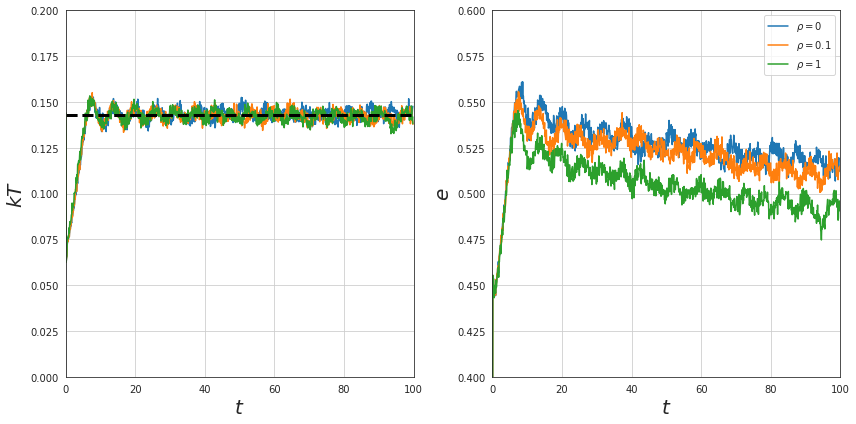

In [ ]:
#@title Plot Results
ts = jnp.arange(0, t_sim, t_md)[:-1]

plt.subplot(1, 2, 1)
for log in logs:
  kT_measured, _ = log
  plt.plot(ts, kT_measured)
plt.plot([0, t_sim], [kT, kT], 'k--', linewidth=3)
plt.ylim([0, 0.2])
plt.xlim([0, t_sim])
format_plot('$t$', '$kT$')

plt.subplot(1, 2, 2)
for rho, log in zip(rhos, logs):
  _, E = log
  plt.plot(ts, E, label=f'$\\rho = {rho}$')
format_plot('$t$', '$e$')
plt.ylim([0.4, 0.6])
plt.xlim([0, t_sim])

plt.legend()
finalize_plot((2, 1))

### Compute $\tau_\alpha$

In [ ]:
#@title Run long equilibration
rhos = [0.1, 1, 10]
t_sims = [2000, 1500, 1200]
N_swaps = [int(rho * N * t_md) for rho in rhos]

kT = 0.105
t_sim = 1500

results = [equilibrate_system(t_sim, kT, N_swap) 
           for t_sim, N_swap in zip(t_sims, N_swaps)]
states, logs = zip(*results)

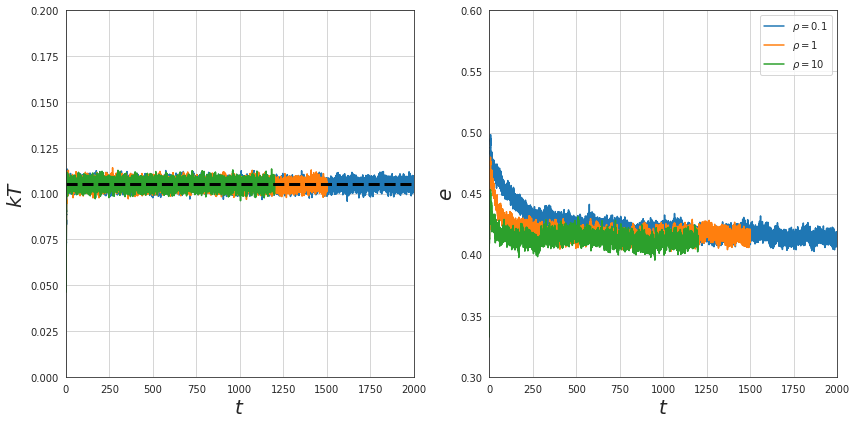

In [ ]:
#@title Plot Results

plt.subplot(1, 2, 1)
for t_sim, log in zip(t_sims, logs):
  kT_measured, _ = log
  ts = jnp.arange(0, t_sim, t_md)[:-1]
  plt.plot(ts, kT_measured)
plt.plot([0, max(t_sims)], [kT, kT], 'k--', linewidth=3)
plt.ylim([0, 0.2])
plt.xlim([0, max(t_sims)])
format_plot('$t$', '$kT$')

plt.subplot(1, 2, 2)
for t_sim, rho, log in zip(t_sims, rhos, logs):
  _, E = log
  ts = jnp.arange(0, t_sim, t_md)[:-1]
  plt.plot(ts, E, label=f'$\\rho = {rho}$')
format_plot('$t$', '$e$')
plt.ylim([0.3, 0.6])
plt.xlim([0, max(t_sims)])

plt.legend()
finalize_plot((2, 1))

In [ ]:
#@title Compute Self Intermediate Scattering Function
def sisf_fn(k, dr):
  return jnp.exp(1j * jnp.dot(k, dr))
sisf_fn = vmap(sisf_fn, (0, None))
sisf_fn = vmap(sisf_fn, (None, 0))

def compute_sisf(t_measure, kT, N_swap, state):
  init_fn, block_fn = hybrid_swap_mc(energy_fn, neighbor_fn, shift, kT, N_swap)

  def step_fn(i, state_ref_sisf):
    state, ref, sisf = state_ref_sisf

    # Record sisf.
    k = jnp.array([[7.0, 0.0, 0.0],
                   [0.0, 7.0, 0.0],
                   [0.0, 0.0, 7.0]])
    r = state.md.position
    d = vmap(displacement)
    sisf = sisf.at[i].set(jnp.mean(sisf_fn(k, d(r, ref))))

    # Run a single MD + SMC block.
    state = block_fn(state)

    return state, ref, sisf

  n_blocks = int(t_measure // t_md)

  sisf = jnp.zeros((n_blocks,))  # SISF

  return fori_loop(0, n_blocks, step_fn, (state, state.md.position, sisf))
compute_sisf = jit(compute_sisf, static_argnums=0)

t_measure = 1000

sisfs = []

for N_swap, state in zip(N_swaps, states):
  _, _, sisf = compute_sisf(t_measure, kT, N_swap, state)
  sisfs += [sisf]

/usr/local/lib/python3.7/dist-packages/jax/_src/lax/lax.py:425: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


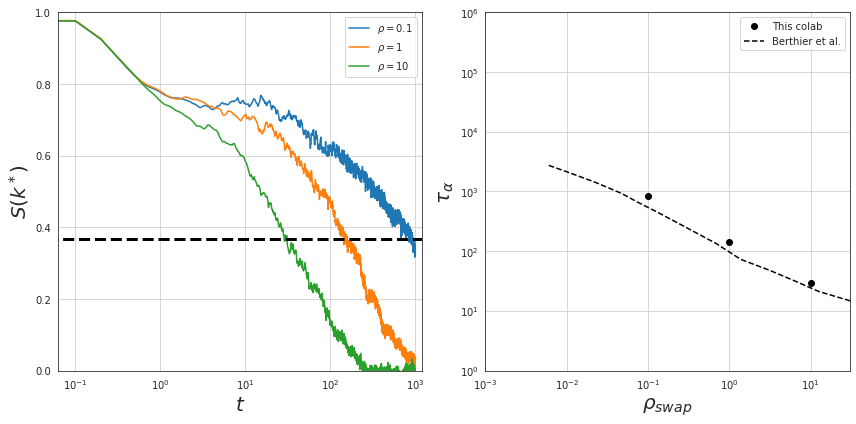

In [ ]:
#@title Plot Results
ts = jnp.arange(0, t_measure, t_md)[:-1]

tau_alpha = []

plt.subplot(1, 2, 1)
for rho, sisf in zip(rhos, sisfs):
  tau = ts[sisf < 1 / jnp.e]
  tau_alpha += [tau[0]]
  plt.semilogx(ts, sisf, label=f'$\\rho = {rho}$')
plt.semilogx([0, t_sim], [1 / jnp.e, 1 / jnp.e], 'k--', linewidth=3)
plt.ylim([0, 1])
plt.xlim([0, t_sim])
plt.legend()
format_plot('$t$', '$S(k^*)$')

plt.subplot(1, 2, 2) 
plt.loglog(rhos, tau_alpha, 'ko', label='This colab')

paper_data_x = [0.006007909807031181, 0.010502110796366664, 0.02255233371701638, 0.04702625836135111, 0.07526546423337163, 0.1315675950384218, 0.2368471074127418, 0.6824055545621013, 1.3817374603050074, 3.146823178800338, 6.561774124160606, 12.527728719443648, 29.38225383971006, 54.471610125383265, 116.97285940611617, 290.95765460447905]
paper_data_y = [2727.433622322005, 2081.7844210638145, 1415.2657243572044, 925.7217057719621, 654.0974531071987, 444.6770263075113, 290.862110363026, 134.42858278804863, 72.49953073371105, 47.421758404387475, 31.01845139417473, 21.087366509536256, 14.899934441013803, 10.942237711543916, 11.37276124350448, 9.377067432117187]
plt.loglog(paper_data_x, paper_data_y, 'k--', label='Berthier et al.')

plt.ylim([1, 10 ** 6])
plt.xlim([10 ** -3, 10 * 3])
format_plot('$\\rho_{swap}$', '$\\tau_\\alpha$')

plt.legend()
finalize_plot((2, 1))


### Benchmarking

In [ ]:
#@title Run Benchmark
import time

def run_benchmark(N, rhos, t_sim):
  n_blocks = int(t_sim // t_md)

  # Initialize the system.
  box_size = quantity.box_size_at_number_density(N, 
                                               number_density, 
                                               spatial_dimension)

  displacement, shift = space.periodic(box_size)
  metric = space.metric(displacement)

  key = random.PRNGKey(0)

  key, pos_key, sigma_key = random.split(key, 3)

  position = random.uniform(pos_key, (N, spatial_dimension)) * box_size 
  sigma = random_sigma(sigma_key, (N,), sigma_min, sigma_max)

  # Setup the energy function.
  energy_fn = smap.pair_neighbor_list(U, metric, sigma=(sigma_fn, sigma))
  neighbor_fn = partition.neighbor_list(displacement, 
                                        box_size, 
                                        cutoff * sigma_max, 
                                        dr_threshold=0.5)
  
  # Do minimization.
  clipped_force_fn = quantity.clipped_force(energy_fn, max_force=1.0)
  fire_init_fn, fire_step_fn = minimize.fire_descent(clipped_force_fn, shift)

  nbrs = neighbor_fn(position)
  fire_state = fire_init_fn(position, neighbor=nbrs)

  def fire_fn(i, state_nbrs):
    state, nbrs = state_nbrs
    state = fire_step_fn(state, neighbor=nbrs)
    nbrs = neighbor_fn(state.position, nbrs)
    return state, nbrs

  fire_state, nbrs = fori_loop(0, 2000, fire_fn, (fire_state, nbrs)) 

  # Benchmark.
  total_times = []
  for rho in rhos:
    N_swap = int(rho * N * t_md)
    init_fn, block_fn = hybrid_swap_mc(energy_fn, neighbor_fn, shift, kT, N_swap)

    state = init_fn(key, fire_state.position, sigma, nbrs)

    def run(n_blocks, state):
      return fori_loop(0, n_blocks, lambda i, state: block_fn(state), state)
    run = jit(run, static_argnums=0)

    # Run once to make sure the jit cache is populated.
    run(n_blocks, state).sigma.block_until_ready()

    # Run three times with timing.
    times = []
    for i in range(3):
      start = time.perf_counter()
      run(n_blocks, state).sigma.block_until_ready()
      end = time.perf_counter()
      times += [end - start]
    total_times += [times]

  return total_times

Ns = (1500, 12000, 120000)
rhos = (0, 1e-3, 1e-2, 1e-1, 1)
times = []

for N in Ns:
  times += [run_benchmark(N, rhos, 10)]

times = jnp.array(times)

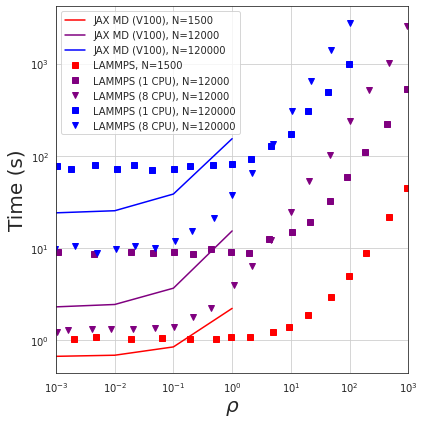

In [ ]:
#@title Plot Results
c1500 = [1, 0, 0]
c12000 = [0.5, 0, 0.5]
c120000 = [0, 0, 1.0]

times = jnp.array(times)
plt.loglog(rhos, jnp.mean(times[0], axis=-1), label='JAX MD (V100), N=1500', color=c1500)
plt.loglog(rhos, jnp.mean(times[1], axis=-1), label='JAX MD (V100), N=12000', color=c12000)
plt.loglog(rhos, jnp.mean(times[2], axis=-1), label='JAX MD (V100), N=120000', color=c120000)

timing_1500_x = [0.002030917620904735, 0.0047806525330073854, 0.019144819761699575, 0.0642232542222936, 0.19144819761699575, 0.5223345074266843, 0.9426684551178854, 2.030917620904735, 4.923882631706737, 9.426684551178845, 19.718405565126417, 47.80652533007385, 97.09111468707553, 191.44819761699577, 478.06525330073754, 942.6684551178854]
timing_1500_y = [1.01953786853273, 1.0874631914219506, 1.01953786853273, 1.0529529449553463, 1.01953786853273, 1.01953786853273, 1.0874631914219506, 1.0874631914219506, 1.2371916345321607, 1.4075355861515766, 1.8815241799500162, 2.955209235202888, 4.950828372400959, 8.846647267651665, 21.82406137003982, 44.366873309786115]

timing_12000_1_x = [0.001092600861117378, 0.004375479375074184, 0.018587918911465634, 0.04506570337745473, 0.102996036580999, 0.21544346900318823, 0.43754793750741844, 0.9426684551178854, 1.9144819761699576, 4.248201698162612, 10.608183551394482, 20.91764655756995, 46.41588833612773, 91.52473108773893, 180.47217668271702, 437.547937507418, 970.9111468707554]
timing_12000_1_y = [9.13659372639178, 8.565902153685496, 9.13659372639178, 8.846647267651665, 9.13659372639178, 8.565902153685496, 9.745306848412376, 9.13659372639178, 8.846647267651665, 12.613637220374436, 14.820687405677521, 19.182851520190315, 32.136812662333526, 59.30744895010559, 109.44997993195443, 222.50457011937894, 531.4840014580977]

timing_12000_8_x = [0.0010299603658099898, 0.001603718743751331, 0.004124626382901352, 0.008627747685955875, 0.020309176209047358, 0.04780652533007383, 0.102996036580999, 0.21544346900318823, 0.43754793750741844, 1.0608183551394483, 2.154434690031882, 4.6415888336127775, 10, 20.309176209047347, 46.41588833612773, 100, 215.44346900318823, 464.1588833612773, 942.6684551178854]
timing_12000_8_y = [1.2371916345321607, 1.2777402539540255, 1.3196178433520256, 1.3196178433520256, 1.3196178433520256, 1.362867959355774, 1.4075355861515766, 1.7640000757273555, 2.2107407427431256, 3.9503780135666444, 6.408002744416, 12.213348058636221, 24.828928805603276, 53.83843622033489, 102.6134954552931, 237.32863427252, 514.6175511468989, 1012.9831955925681, 2580.861540418077]

timing_120000_1_x = [0.0010299603658099898, 0.0018047217668271701, 0.004641588833612777, 0.01092600861117378, 0.021544346900318832, 0.043754793750741844, 0.102996036580999, 0.19144819761699575, 0.47806525330073807, 1, 2.091764655756995, 4.506570337745473, 10, 19.718405565126417, 43.7547937507418, 97.09111468707553]
timing_120000_1_y = [76.76337514650757, 71.96856730011521, 79.27927389450598, 71.96856730011521, 79.27927389450598, 69.68467115083241, 71.96856730011521, 76.76337514650757, 79.27927389450598, 81.87763053988195, 93.15103293454989, 128.60080806105665, 171.90722018585745, 307.18143012686966, 498.28635146473056, 980.8365445406671]

timing_120000_8_x = [0.0009709111468707553, 0.002091764655756995, 0.004923882631706742, 0.010608183551394482, 0.022189823414589707, 0.04923882631706739, 0.10608183551394483, 0.2091764655756995, 0.49238826317067363, 1, 2.154434690031882, 4.923882631706737, 10.2996036580999, 22.189823414589696, 49.238826317067414, 102.99603658099899]
timing_120000_8_y = [9.745306848412376, 10.394574653722627, 8.846647267651665, 9.745306848412376, 10.394574653722627, 10.064706630560913, 11.82576192697614, 15.306431405563595, 21.131482768094166, 37.75989798675419, 65.33201459593776, 132.81566457791624, 307.18143012686966, 644.9466771037627, 1398.4864515351844, 2752.807927968702]

plt.loglog(timing_1500_x, timing_1500_y, 's', label='LAMMPS, N=1500', color=c1500)
plt.loglog(timing_12000_1_x, timing_12000_1_y, 's', label='LAMMPS (1 CPU), N=12000', color=c12000)
plt.loglog(timing_12000_8_x, timing_12000_8_y, 'v', label='LAMMPS (8 CPU), N=12000', color=c12000)
plt.loglog(timing_120000_1_x, timing_120000_1_y, 's', label='LAMMPS (1 CPU), N=120000', color=c120000)
plt.loglog(timing_120000_8_x, timing_120000_8_y, 'v', label='LAMMPS (8 CPU), N=120000', color=c120000)

plt.xlim([10 ** -3, 10 ** 3])

plt.legend()

format_plot('$\\rho$', 'Time (s)')
finalize_plot()

Two Observations:

1. For small $\rho$, JAX MD performance is a bit slower than LAMMPS 8xCPU performance, but is faster than LAMMPS 1xCPU performance.
2. Crossover to regime dominated by swaps happens earlier since GPUs are worse at serial computation.

To improve from here:

1. Improve performance of SMC blocks.
2. Make neighbor lists tighter.
3. Perform SMC blocks on CPU.



## Continuous time Swap MD

In [ ]:
#@title Generate random state.

# Simulation parameters.
N = 1500
number_density = 1.0
spatial_dimension = 3

# Create simulation space.
box_size = quantity.box_size_at_number_density(N, 
                                               number_density, 
                                               spatial_dimension)

displacement, shift = space.periodic(box_size)
metric = space.metric(displacement)

# Randomly initializer positions and radii.
key = random.PRNGKey(0)

key, pos_key, sigma_key = random.split(key, 3)

position = random.uniform(pos_key, (N, spatial_dimension)) * box_size 

sigma_min = 0.73
sigma_max = 1.62
sigma = random.uniform(sigma_key, (N,), minval=sigma_min, maxval=sigma_max) 

# sigma = random_sigma(sigma_key, (N,), sigma_min, sigma_max)

# Create energy function and neighbor list function.
energy_fn = smap.pair_neighbor_list(U, metric, sigma=sigma)

neighbor_fn = partition.neighbor_list(displacement, 
                                      box_size, 
                                      cutoff * (sigma_max + 0.1), 
                                      dr_threshold=0.5)

# Create clipped force function and minimizer.
clipped_force_fn = quantity.clipped_force(energy_fn, max_force=1.0)
init_fn, step_fn = minimize.fire_descent(clipped_force_fn, shift)

# Run minimization.
nbrs = neighbor_fn(position)
state = init_fn(position, neighbor=nbrs)

def body_fn(i, state_nbrs):
  state, nbrs = state_nbrs
  state = step_fn(state, neighbor=nbrs)
  nbrs = neighbor_fn(state.position, nbrs)
  return state, nbrs

state, nbrs = fori_loop(0, 2000, body_fn, (state, nbrs))

minimized_position = state.position

print(f'Energy = {energy_fn(state.position, sigma=sigma, neighbor=nbrs):0.3}.')
print(f'Max Force = {jnp.max(jnp.abs(state.force)):0.3}.')
print(f'Did neighborlist overflow: {nbrs.did_buffer_overflow}.')

Energy = 2.21e+04.
Max Force = 0.756.
Did neighborlist overflow: False.


(0.0, 4.0)

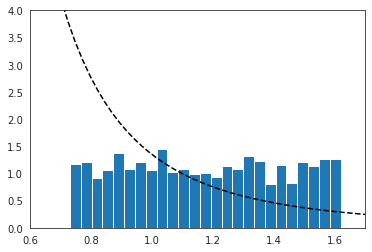

In [ ]:
#@title Plot radii distribution.
plt.hist(sigma, density=True, bins=25)
sigmas = jnp.linspace(0.6, 1.8)
plt.plot(sigmas, 1.35 * sigmas ** -3.2, 'k--')
plt.xlim([0.6, 1.7])
plt.ylim([0, 4])

Simulate according to the extended hamiltonian,

$H(\vec r, \vec p_r, \sigma, p_\sigma) = \sum_i \left(\frac{p_{r_i}^2}{2m} + \frac{p_{\sigma_i}^2}{2M}\right) + U(\vec r, \sigma) + v(\sigma)$

With,

$v(\sigma) = \exp[A(-\lambda_1\sigma + \sigma_m)] + \exp[A(\lambda_2\sigma - \sigma_M)] - D\sigma^n$

In [ ]:
kT = 1.0
dt = 0.001

U_fn = smap.pair_neighbor_list(U, metric, sigma=sigma)

def V_fn(sigma, A=100, lam1=1.0, lam2=1.0, D=14.46, n=2.6):
  E = (jnp.exp(A * (-lam1 * sigma + sigma_min)) + 
       jnp.exp(A * (lam2 * sigma - sigma_max)) - D * sigma ** n)
  return jnp.sum(E)

def energy_fn(R_sigma, neighbor, **kwargs):
  R, sigma = R_sigma
  return U_fn(R, sigma=sigma, neighbor=neighbor) + V_fn(sigma)

In [ ]:
R_sigma = (minimized_position, sigma)
mass = (1.0, 1.0)
swap_shift = (shift, lambda x, dx, **kwargs: x + dx)

init_fn, step_fn = simulate.nvt_nose_hoover(energy_fn, 
                                            swap_shift, 
                                            dt, 
                                            kT=kT, 
                                            chain_length=3)

In [ ]:
log = jnp.zeros((100, N))
def body_fn(i, state_nbrs):
  state, nbrs = state_nbrs
  state = step_fn(state, neighbor=nbrs)
  R, sigma = state.position
  nbrs = neighbor_fn(R, nbrs)
  return state, nbrs

state = init_fn(key, R_sigma, mass, neighbor=nbrs)
final_state, _, = fori_loop(0, 10000, body_fn, (state, nbrs))

(0.0, 4.0)

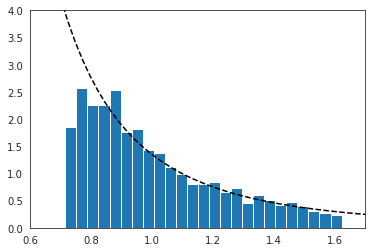

In [ ]:
#@title Plot radii distribution.
R, sigma = final_state.position
plt.hist(sigma, density=True, bins=25)
sigmas = jnp.linspace(0.6, 1.8)
plt.plot(sigmas, 1.35 * sigmas ** -3.2, 'k--')
plt.xlim([0.6, 1.7])
plt.ylim([0, 4])